In [12]:
import pandas as pd
import numpy as np
import csv
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [13]:
numFrame = 18241

In [14]:
filename="../Data/TrainTest/clip_info.csv"
record=[]
with open(filename, 'r') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    #next(spamreader, None)  # skip the headers
    for row in spamreader:
        if row[4] and int(row[4])>=numFrame:
            break
        if row[4] and row[7]!='未擊球' and row[7]!='未過網': 
            record+=[int(row[4])]
            


In [15]:
df = pd.read_csv('../Data/TrainTest/Badminton_label.csv')
df = df[0:numFrame]

marked = [0 for _ in range(numFrame)]
cnt=0
for i in range(numFrame):
    if i+1 in record:
        if df['Visibility'][i]==0:
            marked[i-1]=1
        else:
            marked[i]=1
        cnt+=1
        
df['hitpoint']=marked
df = df[df.Visibility == 1].reset_index(drop=True)

In [16]:
# Absolute position
X = df['X']
Y = df['Y']

# Vector X and Y
vecX = [X[i+1]-X[i] for i in range(len(X)-1)]
vecY = [Y[i+1]-Y[i] for i in range(len(Y)-1)]
vecX.append(0)
vecY.append(0)
dis = [vecX[i]**2+vecY[i]**2 for i in range(len(Y)-1)]
dis.append(0)
df['vecX'] = vecX
df['vecY'] = vecY
df['dis'] = dis
X = df['vecX']
Y = df['vecY']
dX = [X[i+1]-X[i] for i in range(len(X)-1)]
dY = [Y[i+1]-Y[i] for i in range(len(Y)-1)]
dX.append(0)
dY.append(0)
df['dX'] = dX
df['dY'] = dY
muldxdy=[]
for i in range(len(Y)):
    if dX[i]*dY[i]>0:
        muldxdy +=[1]
    else:
        muldxdy +=[0]
df['muldxdy']=muldxdy


##############Only use when using VAE method because VAE input needs normalized #####################
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# df[['X', 'Y','vecX','vecY','dX','dY','muldxdy','dis']] = scaler.fit_transform(df[['X', 'Y','vecX','vecY','dX','dY','muldxdy','dis']])


In [17]:
trainNum = int(len(df[df['hitpoint']==1])*0.7) #328
tmp = df[df['hitpoint']==1].iloc[trainNum]
trainidx = df['Frame'][df['Frame']==tmp['Frame']].index[0]
train = df[0:trainidx+1]
test = df[trainidx+1:]

#solution 2
# new = []
# for i in range(len(train)-3):
#     if train['hitpoint'].iloc[i]==1:
#         new +=[train.iloc[i-3,:]]
#         new +=[train.iloc[i-2,:]]
#         new +=[train.iloc[i-1,:]]
#         new +=[train.iloc[i,:]]
#         new +=[train.iloc[i+1,:]]
#         new +=[train.iloc[i+2,:]]
#         new +=[train.iloc[i+3,:]]
# train = pd.DataFrame(new).reset_index(drop=True)

train_feature = train[['X', 'Y','vecX','vecY','dX','dY','muldxdy','dis']].copy()
train_target  = train[['hitpoint']].copy()
test_feature  = test[['X', 'Y','vecX','vecY','dX','dY','muldxdy','dis']].copy()
test_target  = test[['hitpoint']].copy()

print(len(df[df['hitpoint']==1])-trainNum)
print(len(test_target))
one=0
zero=0
for i in range(len(train_target)):
    if train_target.values[i]==1:
        one+=1
    else:
        zero+=1
        
print("one = ",one)
print("zero = ",zero)

print(train_feature['X'][0])

141
4059
one =  329
zero =  10540
679


# Select K Best(Unused)

In [165]:
from sklearn.feature_selection import SelectKBest
X_new = SelectKBest(k=4).fit(train_feature,train_target)
X_new.get_support(indices=True)

array([1, 4, 5, 7])

# Undersampling

In [238]:
from sklearn.utils import resample
train_downsamp = train[train['hitpoint']==0]
minorNum = len(train[train['hitpoint']==1])
print(minorNum)
train_downsamp = resample(train_downsamp, 
                         replace=False,     # sample with replacement
                         n_samples=minorNum,) # reproducible results
df_downsampled = pd.concat([train_downsamp, train[train['hitpoint']==1]])


329


In [239]:
trainNum = int(len(df[df['hitpoint']==1])*0.7) #328
tmp = df[df['hitpoint']==1].iloc[trainNum]
trainidx = df['Frame'][df['Frame']==tmp['Frame']].index[0]
train = df[0:trainidx+1]
test = df[trainidx+1:]
train_feature = df_downsampled[['X', 'Y','vecX','vecY','dX','dY','muldxdy','dis']].copy()
train_target  = df_downsampled[['hitpoint']].copy()
test_feature  = test[['X', 'Y','vecX','vecY','dX','dY','muldxdy','dis']].copy()
test_target  = test[['hitpoint']].copy()
print(len(df[df['hitpoint']==1])-trainNum)
print(len(train_target))

141
658


# SMOTE for oversampling

In [251]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
train_feature,train_target = sm.fit_sample(train_feature, train_target.values.ravel())
print(np.shape(train_feature))
print(np.shape(train_target))
print(np.shape(test_feature))
print(np.shape(test_target))
print(sorted(Counter(train_target).items()))
train_target

(21080, 8)
(21080,)
(4059, 8)
(4059, 1)
[(0, 10540), (1, 10540)]


array([0, 0, 0, ..., 1, 1, 1])

# Combination of over and under sampling by SMOTE+ENN

In [262]:
from imblearn.combine import SMOTEENN
sme = SMOTEENN(sampling_strategy=0.5)
train_feature,train_target = sme.fit_resample(train_feature, train_target.values.ravel())
print(np.shape(train_feature))
print(np.shape(train_target))
print(np.shape(test_feature))
print(np.shape(test_target))
print(sorted(Counter(train_target).items()))


(13760, 8)
(13760,)
(4059, 8)
(4059, 1)
[(0, 9055), (1, 4705)]


# ADASYN

In [277]:
from imblearn.over_sampling import ADASYN 
sme = ADASYN ()
train_feature,train_target = sme.fit_resample(train_feature, train_target.values.ravel())
print(np.shape(train_feature))
print(np.shape(train_target))
print(np.shape(test_feature))
print(np.shape(test_target))
print(sorted(Counter(train_target).items()))


(20977, 8)
(20977,)
(4059, 8)
(4059, 1)
[(0, 10540), (1, 10437)]


# Combination of over and under sampling by SMOTE+TOMEK

In [412]:
from imblearn.combine import SMOTETomek
smt = SMOTEENN(sampling_strategy=0.5)
train_feature,train_target = smt.fit_resample(train_feature, train_target.values.ravel())
print(np.shape(train_feature))
print(np.shape(train_target))
print(np.shape(test_feature))
print(np.shape(test_target))
print(sorted(Counter(train_target).items()))

(11178, 2)
(11178,)
(4059, 2)
(4059, 1)
[(0, 8149), (1, 3029)]


# Only for checking

In [39]:
print(np.shape(train_feature))
print(np.shape(train_target))
print(np.shape(test_feature))
print(np.shape(test_target))
one=0
zero=0
for i in range(len(test_target)):
    if test_target.values[i]==1:
        one+=1
    else:
        zero+=1
        
print("one = ",one)
print("zero = ",zero)

(11198, 8)
(11198, 1)
(4059, 8)
(4059, 1)
one =  658
zero =  10540


# KNN

In [49]:
from sklearn.neighbors import KNeighborsClassifier
acc = []
idx = []
cor =[]
for i in range(1,10):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(train_feature,train_target)
    score = neigh.score(test_feature,test_target.values.ravel())
    pred = neigh.predict(test_feature)
    corzero = 0
    corone = 0
    correct = 0
    for j in range(len(pred)):
        if pred[j] == test_target.values[j]:
            if pred[j]==1:
                corone +=1
            else :
                corzero +=1
            correct+=1
    cor += [correct]
    acc += [score]
    idx += [i]
    print("iteration = ",i)
    print("accuracy = ",score)
    print("my accuracy zero= ",corzero)
    print("my accuracy one= ",corone)
    print("predict rate = ",roc_auc_score(test_target.values.ravel(), pred))

iteration =  1
accuracy =  0.9095836412909584
my accuracy zero=  3650
my accuracy one=  42
predict rate =  0.6156800204133708
iteration =  2
accuracy =  0.9300320275930032
my accuracy zero=  3746
my accuracy one=  29
predict rate =  0.5814994714395072
iteration =  3
accuracy =  0.9081054446908106
my accuracy zero=  3652
my accuracy one=  34
predict rate =  0.5873637589764154
iteration =  4
accuracy =  0.9231337767923133
my accuracy zero=  3720
my accuracy one=  27
predict rate =  0.5710394415485
iteration =  5
accuracy =  0.9068736141906873
my accuracy zero=  3646
my accuracy one=  35
predict rate =  0.5901696861444246
iteration =  6
accuracy =  0.9182064547918206
my accuracy zero=  3697
my accuracy one=  30
predict rate =  0.5788193052163452
iteration =  7
accuracy =  0.9068736141906873
my accuracy zero=  3648
my accuracy one=  33
predict rate =  0.5832819961360405
iteration =  8
accuracy =  0.9260901699926091
my accuracy zero=  3731
my accuracy one=  28
predict rate =  0.576014289359

In [43]:
def checkresult(model):
    model.fit(train_feature,train_target)
    score = model.score(test_feature,test_target.values.ravel())
    pred = model.predict(test_feature)
    corzero = 0
    corone = 0
    correct = 0

    for j in range(len(pred)):
        if pred[j] == test_target.values[j]:
            if pred[j]==1:
                corone +=1
            else :
                corzero +=1
            correct+=1

    one=0
    zero=0
    for i in range(len(pred)):
        if pred[i]==1:
            one+=1
        else:
            zero+=1

    print("one = ",one)
    print("zero = ",zero)

    print("accuracy = ",score)
    print("my accuracy zero = ",corzero)
    print("my accuracy one = ",corone)
    print("predict rate = ",roc_auc_score(test_target.values.ravel(), pred))
    
    print(classification_report(test_target.values.ravel(), pred))

# Random Forest

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
rf = RandomForestClassifier(max_depth = 4,n_estimators=5)

checkresult(rf)
print(rf.feature_importances_)

one =  3856
zero =  203
accuracy =  0.016506528701650654
my accuracy zero =  65
my accuracy one =  2
predict rate =  0.01543578901323225
              precision    recall  f1-score   support

           0       0.32      0.02      0.03      3919
           1       0.00      0.01      0.00       140

   micro avg       0.02      0.02      0.02      4059
   macro avg       0.16      0.02      0.02      4059
weighted avg       0.31      0.02      0.03      4059

[0.00085975 0.0089834  0.25414006 0.01129725 0.53743093 0.03055889
 0.13234649 0.02438324]


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


# Decision Tree

In [280]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import precision_recall_curve

tree = DecisionTreeClassifier(max_depth = 4)
checkresult(tree)
print(tree.feature_importances_)

one =  1423
zero =  2636
accuracy =  0.672579453067258
my accuracy zero =  2613
my accuracy one =  117
predict rate =  0.7512330040462218
              precision    recall  f1-score   support

           0       0.99      0.67      0.80      3919
           1       0.08      0.84      0.15       140

   micro avg       0.67      0.67      0.67      4059
   macro avg       0.54      0.75      0.47      4059
weighted avg       0.96      0.67      0.77      4059

[0.         0.18125948 0.         0.07827425 0.05612966 0.43148619
 0.         0.25285042]


In [36]:
print(test_feature.keys())
export_graphviz(tree, out_file='tree.dot', feature_names=test_feature.keys())
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

Index(['X', 'Y', 'vecX', 'vecY', 'dX', 'dY', 'muldxdy', 'dis'], dtype='object')


0

# Logistic Regression

In [281]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=100)
checkresult(lr)

one =  802
zero =  3257
accuracy =  0.8093126385809313
my accuracy zero =  3201
my accuracy one =  84
predict rate =  0.7083949987241643
              precision    recall  f1-score   support

           0       0.98      0.82      0.89      3919
           1       0.10      0.60      0.18       140

   micro avg       0.81      0.81      0.81      4059
   macro avg       0.54      0.71      0.54      4059
weighted avg       0.95      0.81      0.87      4059



/home/ino/anaconda3/envs/TrackNet/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# Gaussian Naive Bayes

In [282]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
checkresult(gnb)

one =  383
zero =  3676
accuracy =  0.9046563192904656
my accuracy zero =  3604
my accuracy one =  68
predict rate =  0.7026683191776327
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      3919
           1       0.18      0.49      0.26       140

   micro avg       0.90      0.90      0.90      4059
   macro avg       0.58      0.70      0.60      4059
weighted avg       0.95      0.90      0.93      4059



# SVC

In [131]:
from sklearn.svm import SVC
svc = SVC(C=1.0,class_weight='balanced',probability=True)
checkresult(svc)

/home/ino/anaconda3/envs/TrackNet/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


one =  0
zero =  4059
accuracy =  0.9655087459965509
my accuracy zero =  3919
my accuracy one =  0
predict rate =  0.5
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3919
           1       0.00      0.00      0.00       140

   micro avg       0.97      0.97      0.97      4059
   macro avg       0.48      0.50      0.49      4059
weighted avg       0.93      0.97      0.95      4059



/home/ino/anaconda3/envs/TrackNet/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# DNN

In [529]:
from keras.models import Sequential
from keras.layers import Input, Flatten,Dropout
from keras.layers.core import Dense,Activation
from keras.layers.convolutional import Conv1D
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.optimizers import  Adam,nadam,SGD,adadelta
from keras import optimizers
from keras.utils import plot_model,to_categorical
def build_model(unit_size,drop_rate):
    input_size =8
    model = Sequential()
    #add model layer
    model.add(Dense(input_dim=input_size,units=unit_size,kernel_initializer='random_uniform'))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Dropout(drop_rate))
    
    model.add(Dense(units=unit_size,kernel_initializer='random_uniform'))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Dropout(drop_rate))
    
    model.add(Dense(units=2,kernel_initializer='random_uniform'))
    model.add(Activation('sigmoid'))
    model.summary()
    return model
    
print("done!")

done!


In [591]:
from keras.utils import to_categorical
train_target_nn  = to_categorical(train_target, num_classes=None)
test_target_nn  = to_categorical(test_target, num_classes=None)
np.shape(train_target_nn)

(1467, 2)

In [592]:
from keras.callbacks import TensorBoard
unit_size = 4
drop_rate = 0.2
bsize = 4
epoch = 50
model = build_model(unit_size,drop_rate)

model.compile(loss='binary_crossentropy',optimizer='nadam',metrics=['accuracy'])
history = model.fit(train_feature,train_target_nn,batch_size=bsize,epochs=epoch,callbacks=[TensorBoard(log_dir='./tmp', histogram_freq=0,  
          write_graph=True, write_images=True)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 4)                 36        
_________________________________________________________________
activation_58 (Activation)   (None, 4)                 0         
_________________________________________________________________
batch_normalization_39 (Batc (None, 4)                 16        
_________________________________________________________________
dropout_23 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_59 (Dense)             (None, 4)                 20        
_________________________________________________________________
activation_59 (Activation)   (None, 4)                 0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 4)                 16        
__________

In [593]:
print("=========below is DNN================")

score = model.evaluate(train_feature,train_target_nn,batch_size=bsize)
print ('\nTrain Acc:', score[1])

score = model.evaluate(test_feature,test_target_nn,batch_size=bsize)
print ('\nTest Acc:', score[1])

=========below is DNN================
1467/1467 [==============================] - 1s 669us/step

Train Acc: 0.5923653715064758
4059/4059 [==============================] - 1s 203us/step

Test Acc: 0.03449125400344913


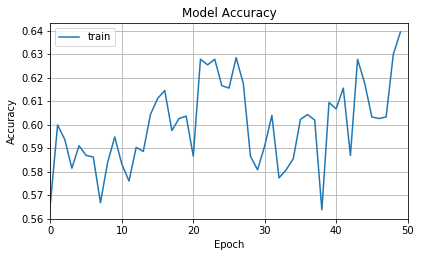

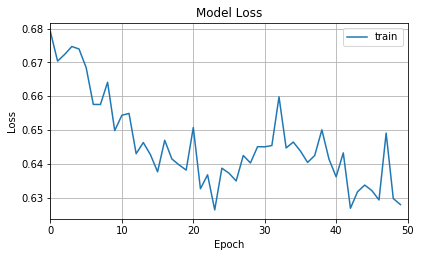

In [594]:
plt.figure(figsize=(6.4,3.6))
plt.plot(history.history['acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xlim(0, epoch)
plt.legend(['train'])
plt.grid()
plt.show()
# "Loss"
plt.figure(figsize=(6.4,3.6))
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim(0, epoch)
# plt.ylim(0.6, 0.8)
plt.legend(['train'])
plt.grid()
plt.show()

In [595]:
pred = model.predict(test_feature)
corzero = 0
corone = 0
correct = 0

for j in range(len(pred)):
    if np.argmax(pred[j]) == np.argmax(test_target_nn[j]):
        if np.argmax(pred[j])==1:
            corone +=1
        else :
            corzero +=1
        correct+=1

one=0
zero=0
for i in range(len(pred)):
    if np.argmax(pred[i])==1:
        one+=1
    else:
        zero+=1

print("one = ",one)
print("zero = ",zero)
        
print("my accuracy zero = ",corzero)
print("my accuracy one = ",corone)
print("my accuracy = ",correct/len(pred))
result = np.argmax(pred[:])
result = [np.argmax(pred[i]) for i in range(len(pred))]
# print(result)
print(classification_report(test_target.values.ravel(), result))

one =  4059
zero =  0
my accuracy zero =  0
my accuracy one =  140
my accuracy =  0.03449125400344913
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3919
           1       0.03      1.00      0.07       140

   micro avg       0.03      0.03      0.03      4059
   macro avg       0.02      0.50      0.03      4059
weighted avg       0.00      0.03      0.00      4059



/home/ino/anaconda3/envs/TrackNet/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# T-SNE

In [97]:
from sklearn import manifold
tsne = manifold.TSNE(n_components=2, init='pca')
X_tsne = tsne.fit_transform(train_feature)

print("Org data dimension is = ",train_feature.shape[-1])
print("Embedded data dimension is = ", X_tsne.shape[-1])

Org data dimension is =  8
Embedded data dimension is =  2


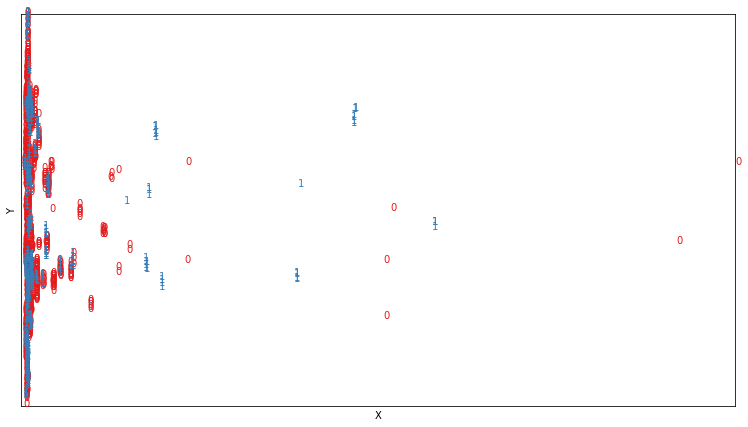

In [102]:
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  
plt.figure(figsize=(12.8,7.2))
for i in range(X_norm.shape[0]):
    plt.text(X_norm[i, 0], X_norm[i, 1], str(train_target[i]), color=plt.cm.Set1(train_target[i]))
plt.xticks([])
plt.yticks([])
plt.grid()
plt.xlabel('X')
plt.ylabel('Y')
# plt.xlim(0,0.5)
plt.show()

[[0.0045131  0.49425313]
 [0.00095823 0.51340723]
 [0.00685659 0.5521405 ]
 ...
 [0.017225   0.42739016]
 [0.02810286 0.34290794]
 [0.00323496 0.172987  ]]
(848,)
(848,)


Text(0.5, 1.0, '2D Trajectory')

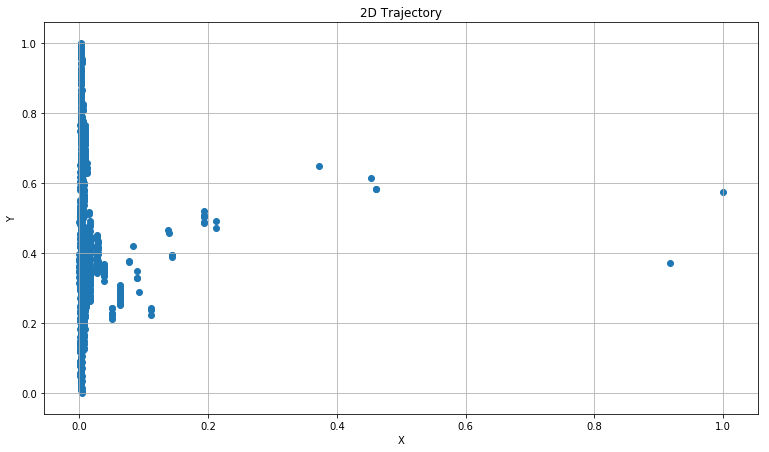

In [80]:
print(X_norm)
# print(X_norm[:,1])
print(np.shape(X_norm[:,0]))
print(np.shape(X_norm[:,1]))
plt.figure(figsize=(12.8,7.2))
plt.scatter(X_norm[:,0], X_norm[:,1])

for i in range(X_norm.shape[0]):
    plt.text(X_norm[i, 0], X_norm[i, 1], str(y[i]), color=plt.cm.Set1(y[i]), 
             fontdict={'weight': 'bold', 'size': 9})

plt.grid()
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(500, 800)
plt.title('T-SNE')

# VAE

In [18]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [19]:
trainNum = int(len(df[df['hitpoint']==1])*0.7) #328
tmp = df[df['hitpoint']==1].iloc[trainNum]
trainidx = df['Frame'][df['Frame']==tmp['Frame']].index[0]
train = df[0:trainidx+1]
test = df[trainidx+1:]

print("one = ",one)
print("zero = ",zero)


print("Before size = ",np.shape(train))
train_vae = train[train.hitpoint == 1].reset_index(drop=True)
test_vae = test[test.hitpoint == 1].reset_index(drop=True)

train = train[train.hitpoint == 0].reset_index(drop=True)
test = test[test.hitpoint == 0].reset_index(drop=True)
print("Drop size = ",np.shape(train))
train_feature_vae = train_vae[['X', 'Y','vecX','vecY','dX','dY','muldxdy','dis']].copy()
train_target_vae  = train_vae[['hitpoint']].copy()
test_feature_vae  = test_vae[['X', 'Y','vecX','vecY','dX','dY','muldxdy','dis']].copy()
test_target_vae  = test_vae[['hitpoint']].copy()


train_feature = train[['X', 'Y','vecX','vecY','dX','dY','muldxdy','dis']].copy()
train_target  = train[['hitpoint']].copy()
test_feature  = test[['X', 'Y','vecX','vecY','dX','dY','muldxdy','dis']].copy()
test_target  = test[['hitpoint']].copy()
print(len(df[df['hitpoint']==1])-trainNum)
print(len(test_target))
one=0
zero=0
for i in range(len(test_target)):
    if test_target.values[i]==1:
        one+=1
    else:
        zero+=1
        
print("one = ",one)
print("zero = ",zero)

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# train_feature_vae = scaler.fit_transform(train_feature_vae)

# scaler = MinMaxScaler()
# test_feature_vae = scaler.fit_transform(test_feature_vae)

# scaler = MinMaxScaler()
# train_feature = scaler.fit_transform(train_feature)

# scaler = MinMaxScaler()
# test_feature = scaler.fit_transform(test_feature)


one =  329
zero =  10540
Before size =  (10869, 11)
Drop size =  (10540, 11)
141
3919
one =  0
zero =  3919


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.utils import plot_model
from keras.losses import mse, binary_crossentropy

original_dim = 8
# network parameters
input_shape = (original_dim, )
intermediate_dim = 4
batch_size = 1
latent_dim = 2
epochs = 500

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

# reconstruction_loss = binary_crossentropy(inputs,outputs)
reconstruction_loss = mse(inputs,outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss, axis=-1)

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 8)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 4)            36          encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            10          dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            10          dense_1[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

In [21]:
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
plot_model(vae,
           to_file='vae_mlp.png',
           show_shapes=True)

vae.fit(train_feature_vae,epochs=epochs,batch_size=batch_size,validation_data=(test_feature_vae,None))
vae.save_weights('vae_mlp_mnist.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 8)                 0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 56        
_________________________________________________________________
decoder (Model)              (None, 8)                 52        
Total params: 108
Trainable params: 108
Non-trainable params: 0
_________________________________________________________________
Train on 329 samples, validate on 140 samples
Epoch 1/500
329/329 [==============================] - 2s 6ms/step - loss: nan - val_loss: nan
Epoch 2/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 3/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 4/500
329/329 [==============================] - 1s 2ms/step - loss: na

329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 79/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 80/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 81/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 82/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 83/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 84/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 85/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 86/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 87/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 88/500
329/329 [==============================]

Epoch 163/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 164/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 165/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 166/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 167/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 168/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 169/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 170/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 171/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 172/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 173/500
329/329 [=======

329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 248/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 249/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 250/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 251/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 252/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 253/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 254/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 255/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 256/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 257/500
329/329 [=====================

329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 332/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 333/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 334/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 335/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 336/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 337/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 338/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 339/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 340/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 341/500
329/329 [=====================

329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 416/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 417/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 418/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 419/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 420/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 421/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 422/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 423/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 424/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 425/500
329/329 [=====================

329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 500/500
329/329 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan


In [ ]:

tmp = vae.predict(train_stand)
print(tmp[0:10])

In [ ]:
train_feature = np.concatenate((train_feature,train_feature_vae,tmp))
train_target = np.concatenate((train_target,train_target_vae,train_target_vae))
test_feature = np.concatenate((test_feature,test_feature_vae))
test_target = np.concatenate((test_target,test_target_vae))

print(np.shape(train_feature))
print(np.shape(train_target))
print(np.shape(test_feature))
print(np.shape(test_target))

In [12]:
train_feature = np.concatenate((train_feature,train_feature_vae))
train_target = np.concatenate((train_target,train_target_vae))
for i in range(50):
    tmp = vae.predict(train_stand)
    train_feature = np.concatenate((train_feature,tmp))
    train_target = np.concatenate((train_target,train_target_vae))
    

NameError: name 'train_feature' is not defined

In [13]:
test_feature = np.concatenate((test_feature,test_feature_vae))
test_target = np.concatenate((test_target,test_target_vae))

NameError: name 'test_feature' is not defined

In [14]:
one=0
zero=0
for i in range(len(test_target)):
    if test_target[i]==1:
        one+=1
    else:
        zero+=1

print("one = ",one)
print("zero = ",zero)
print("before : ")
print(train_feature[0:10])
print(test_feature[0:10])
train_feature=scaler.inverse_transform(train_feature)
test_feature=scaler.inverse_transform(test_feature)
print("after : ")
print(train_feature[0:10])
print(test_feature[0:10])

NameError: name 'test_target' is not defined

In [15]:
print(test_feature[100:110])

NameError: name 'test_feature' is not defined

In [16]:
def checkresult_vae(model):
    model.fit(train_feature,train_target)
    score = model.score(test_feature,test_target)
    pred = model.predict(test_feature)
    corzero = 0
    corone = 0
    correct = 0

    for j in range(len(pred)):
        if pred[j] == test_target[j]:
            if pred[j]==1:
                corone +=1
            else :
                corzero +=1
            correct+=1
            
    one=0
    zero=0
    for i in range(len(train_target)):
        if train_target[i]==1:
            one+=1
        else:
            zero+=1

    print("one = ",one)
    print("zero = ",zero)

    one=0
    zero=0
    for i in range(len(pred)):
        if pred[i]==1:
            one+=1
        else:
            zero+=1

    print("one = ",one)
    print("zero = ",zero)

    print("accuracy = ",score)
    print("my accuracy zero = ",corzero)
    print("my accuracy one = ",corone)
    print("predict rate = ",roc_auc_score(test_target, pred))
    
    print(classification_report(test_target, pred))

In [17]:
print(np.shape(train_feature))
print(np.shape(train_target))
print(np.shape(test_feature))
print(np.shape(test_target))
one=0
zero=0
for i in range(len(train_target)):
    if train_target[i]==1:
        one+=1
    else:
        zero+=1
        
print("one = ",one)
print("zero = ",zero)

NameError: name 'train_feature' is not defined

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
rf = RandomForestClassifier(max_depth = 8,n_estimators=10)

checkresult_vae(rf)
print(rf.feature_importances_)

NameError: name 'train_feature' is not defined

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import precision_recall_curve

tree = DecisionTreeClassifier(max_depth = 4)
checkresult_vae(tree)
print(tree.feature_importances_)

In [19]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=100)
checkresult_vae(lr)

NameError: name 'train_feature' is not defined

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
checkresult_vae(gnb)